# Initialize

In [1]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab_Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks


In [2]:
noc_region = pd.read_csv('noc_regions.csv')
athletes = pd.read_csv('athlete_events.csv')

In [3]:
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26771 sha256=1df3c7ee039876767c695f14e89f8d2a2d3f787083e40f4876794eeee1b638b7
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [5]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Merge data
data = pd.merge(athletes, noc_region, how='left', left_on='NOC', right_on='NOC')

# **Project guideline**



## **Project Proposal**
For this project, I aim to understand the performance of different countries or regions (NOC) in specific sports over time, the evolution of their participation in the Olympic Games, and the patterns or trends in athletes’ performance related to factors such as age, height, and weight.

## **Questions:**
**Q1:** Which countries or regions (NOC) have had better performance in specific sports over time? </br>
**Q2:** How has the participation of different countries and regions (NOC) in the Olympic Games evolved over the years, and how does their performance compare to each other? </br>
**Q3:** Are there patterns or trends in athletes, performance related to factors such as age, height, and weight?

## **Initial Hypotheses:**
**H1:** Certain countries/regions have consistently dominated in specific sports due to cultural factors, sports programs, and geographical conditions. </br>
**H2:** Athletes in strength and endurance sports tend to be in an optimal age and physical characteristics range. </br>
**H3:** The participation of developing countries/regions has increased in recent decades, showing greater diversity in the Olympic Games. </br>
**H4:** There is a positive correlation between optimal physical characteristics (height, weight) and success in certain sports.

## **01. Which client/dataset did you select and why?**
I selected the Client 3: SportsStats (Olympics Dataset - 120 years of data)

SportsStats is a sports analysis firm partnering with local news and elite personal trainers to provide “interesting” insights to help their partners. Insights could be patterns/trends highlighting certain groups/events/countries, etc. for the purpose of developing a news story or discovering key health insights.

I chose this dataset due to the smaller file size compared to the other options.

## **02. Describe the steps you took to import and clean the data.**
As the data is available in a CSV file, I imported it into a Notebook to perform my first analyzes using Python. To perform the cleanup I removed duplicate values, to understand the number of athletes involved in the games, and also some of the empty values.

![Texto alternativo](ERD.png)

## Q1: Which countries or regions (NOC) have had better performance in specific sports over time?


In [ ]:
# Numerical values for each medal
medal_values = {'Gold': 3, 'Silver': 2, 'Bronze': 1}

# Group and calculate by NOC
medal_score = data.groupby(['NOC', 'Sport', 'Medal'])['Medal'].count().reset_index(name='Count')
medal_score['Score'] = medal_score['Medal'].map(medal_values) * medal_score['Count']

medal_score_total = medal_score.groupby(['NOC', 'Sport'])['Score'].sum().reset_index()

# Identify NOC whit highest score by sport
top_noc_per_sport_score = medal_score_total.loc[medal_score_total.groupby('Sport')['Score'].idxmax()]
top_noc_per_sport_score = top_noc_per_sport_score.sort_values(by='Score', ascending=False)

# Erase index column
top_noc_per_sport_score.reset_index(drop=True, inplace=True)

print("Based score view:")
print(top_noc_per_sport_score)
#print("\n")


# Now view for each kind of medal
medal_count = medal_score.pivot_table(index=['NOC', 'Sport'], columns='Medal', values='Count', fill_value=0).reset_index()
medal_count = medal_count[['NOC', 'Sport', 'Gold', 'Silver', 'Bronze']]

medal_count = medal_count.sort_values(by='Gold', ascending=False)

medal_count.reset_index(drop=True, inplace=True)

print("View based on number of medals by type:")
#print(medal_count.head())
medal_count

Based score view:
    NOC          Sport  Score
0   USA       Swimming   2630
1   USA      Athletics   2481
2   USA     Basketball    927
3   CAN     Ice Hockey    881
4   USA         Rowing    848
..  ...            ...    ...
61  GBR      Triathlon     10
62  USA          Roque      6
63  ESP  Basque Pelota      6
64  GBR   Jeu De Paume      3
65  SUI    Aeronautics      3

[66 rows x 3 columns]
View based on number of medals by type:


Medal,NOC,Sport,Gold,Silver,Bronze
0,USA,Swimming,649,254,175
1,USA,Athletics,542,317,221
2,USA,Basketball,281,24,36
3,CAN,Ice Hockey,220,93,35
4,USA,Rowing,186,101,88
...,...,...,...,...,...
1444,JPN,Fencing,0,5,0
1445,JPN,Football,0,18,16
1446,JPN,Hockey,0,11,0
1447,JPN,Sailing,0,2,2


## Q2: How has the participation of different countries and regions (NOC) in the Olympic Games evolved over the years, and how does their performance compare to each other?

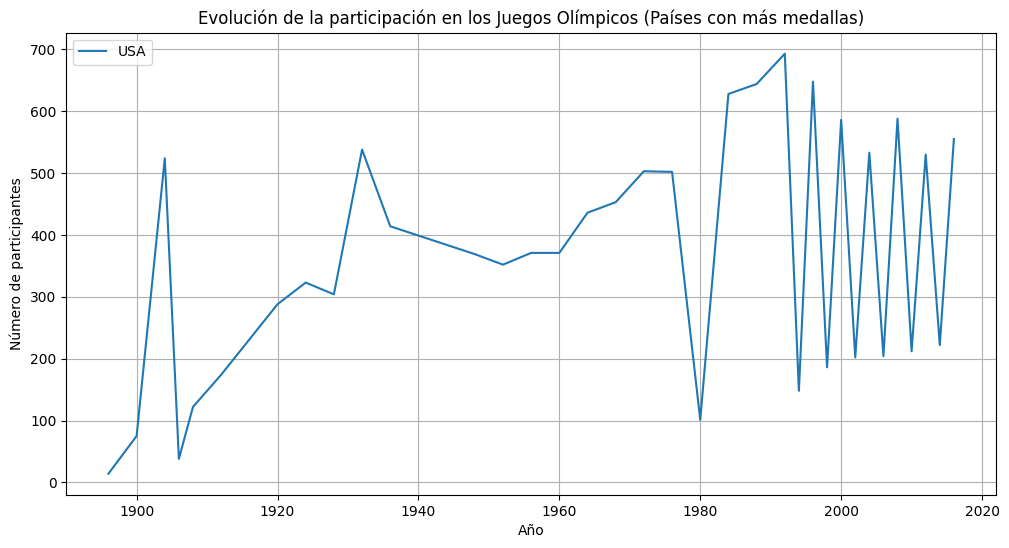

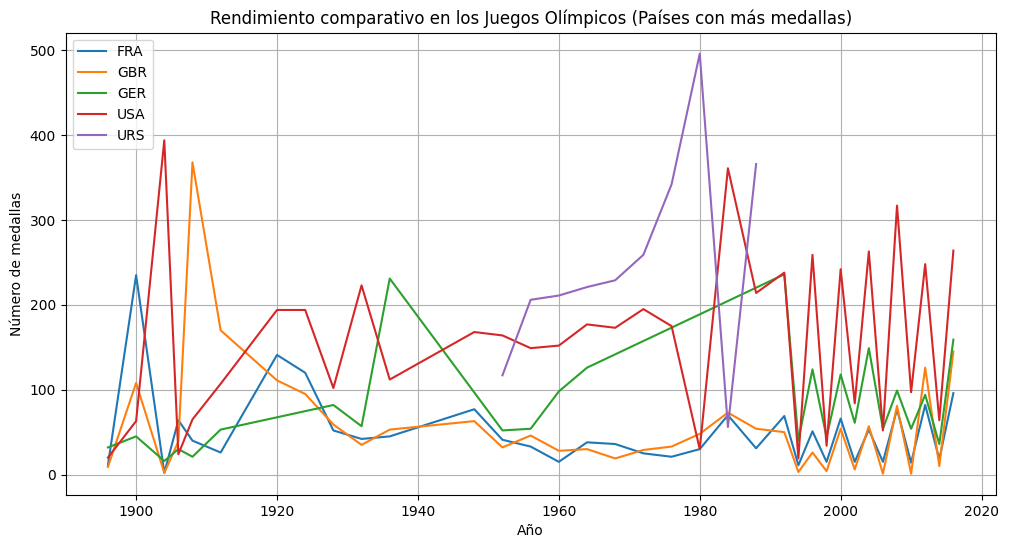

In [ ]:
# Analysis of participation evolution
participation_evolution = data.groupby(['Year', 'region'])['ID'].nunique().reset_index()
participation_evolution.rename(columns={'ID': 'Participants'}, inplace=True)

# Performance analysis: Count medals by country, year, and medal type
medal_recount = data.groupby(['Year', 'NOC', 'Medal'])['ID'].count().reset_index()

# Sum medals by country and year
medal_recount['Medal_Count'] = medal_recount.groupby(['Year', 'NOC'])['ID'].transform('sum')

# Select only rows with medals
medal_recount = medal_recount[medal_recount['Medal'].notnull()]

# Drop duplicates and keep only one row per country and year
medal_recount = medal_recount.drop_duplicates(subset=['Year', 'NOC'])

noc_continent = noc_region[['NOC', 'region']].drop_duplicates()
medal_recount = pd.merge(medal_recount, noc_continent, how='left', on='NOC')

# Select countries or regions with the highest total number of medals
top_countries = medal_recount.groupby('NOC')['Medal_Count'].sum().nlargest(5).index.tolist()

# Filter data to include only selected countries
participation_evolution_filtered = participation_evolution[participation_evolution['region'].isin(top_countries)]
medal_count_filtered = medal_recount[medal_recount['NOC'].isin(top_countries)]

# Display
plt.figure(figsize=(12, 6))
for region in participation_evolution_filtered['region'].unique():
    plt.plot(participation_evolution_filtered[participation_evolution_filtered['region'] == region]['Year'],
             participation_evolution_filtered[participation_evolution_filtered['region'] == region]['Participants'],
             label=region)
plt.title('Evolución de la participación en los Juegos Olímpicos (Países con más medallas)')
plt.xlabel('Año')
plt.ylabel('Número de participantes')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for noc in medal_count_filtered['NOC'].unique():
    plt.plot(medal_count_filtered[medal_count_filtered['NOC'] == noc]['Year'],
             medal_count_filtered[medal_count_filtered['NOC'] == noc]['Medal_Count'],
             label=noc)
plt.title('Rendimiento comparativo en los Juegos Olímpicos (Países con más medallas)')
plt.xlabel('Año')
plt.ylabel('Número de medallas')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


Select an option:
1. View total history by country.
2. Filter by country and sport.
Enter the number of the option you want: 2
Enter the country code (NOC): USA
Enter the sport: Swimming


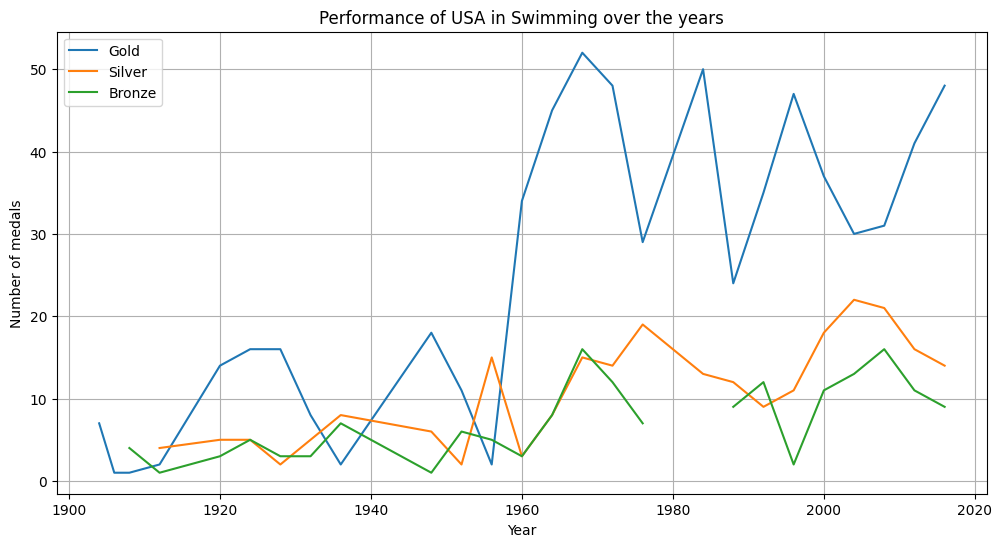

In [ ]:
# Main menu
print("Select an option:")
print("1. View total history by country.")
print("2. Filter by country and sport.")
option = input("Enter the number of the option you want: ")

if option == '1':
    # Option to view performance over the years of a country
    country_input = input("Enter the country code (NOC) to view its performance over the years: ")
    if country_input in medal_recount['NOC'].unique():
        country_data = medal_recount[medal_recount['NOC'] == country_input]
        if not country_data.empty:
            plt.figure(figsize=(12, 6))
            plt.plot(country_data['Year'], country_data['Medal_Count'])
            plt.title(f'Performance of {country_input} in the Olympic Games over the years')
            plt.xlabel('Year')
            plt.ylabel('Number of medals')
            plt.grid(True)
            plt.show()
        else:
            print("There are no medal data for this country in the database.")
    else:
        print("The entered country is not in the database.")

elif option == '2':
    # Option to filter by country and sport
    country_input = input("Enter the country code (NOC): ")
    sport_input = input("Enter the sport: ")
    if country_input in medal_recount['NOC'].unique() and sport_input in data['Sport'].unique():
        country_sport_data = data[(data['NOC'] == country_input) & (data['Sport'] == sport_input)]
        if not country_sport_data.empty:
            # Check for medals before plotting the graph
            if 'Year' in country_sport_data.columns:
                gold_data = country_sport_data[country_sport_data['Medal'] == 'Gold'].groupby('Year')['ID'].count()
                silver_data = country_sport_data[country_sport_data['Medal'] == 'Silver'].groupby('Year')['ID'].count()
                bronze_data = country_sport_data[country_sport_data['Medal'] == 'Bronze'].groupby('Year')['ID'].count()

                # Combine data series into a DataFrame
                medal_count_country_sport = pd.DataFrame({'Gold': gold_data, 'Silver': silver_data, 'Bronze': bronze_data}).reset_index()

                plt.figure(figsize=(12, 6))
                plt.plot(medal_count_country_sport['Year'], medal_count_country_sport['Gold'], label='Gold')
                plt.plot(medal_count_country_sport['Year'], medal_count_country_sport['Silver'], label='Silver')
                plt.plot(medal_count_country_sport['Year'], medal_count_country_sport['Bronze'], label='Bronze')
                plt.title(f'Performance of {country_input} in {sport_input} over the years')
                plt.xlabel('Year')
                plt.ylabel('Number of medals')
                plt.legend(loc='upper left')
                plt.grid(True)
                plt.show()
            else:
                print("There are no medal data for this country and sport in the database.")
        else:
            print("There are no medal data for this country and sport in the database.")
    else:
        print("The entered data is not in the database.")

else:
    print("Invalid option.")


## Q3: Are there patterns or trends in athletes’ performance related to factors such as age, height, and weight?



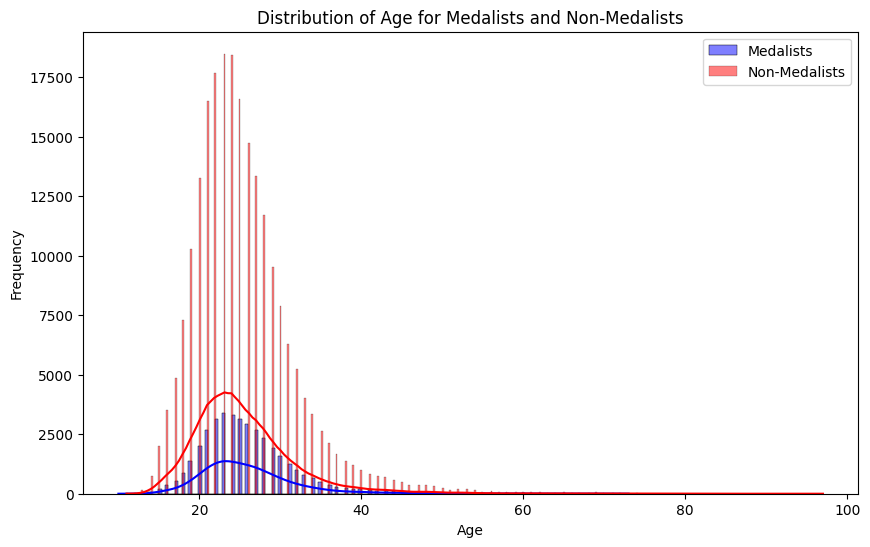

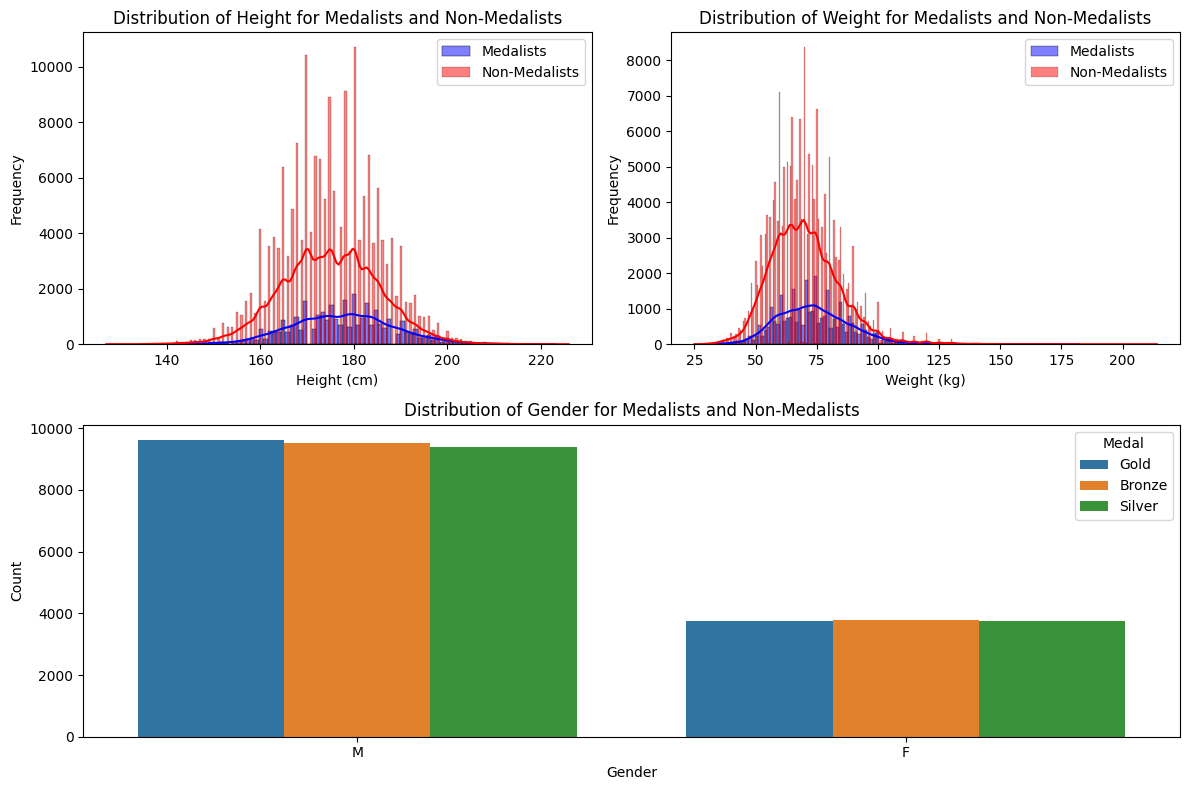

In [ ]:
# Filter the data for athletes who won medals and those who did not
medalists = data[data['Medal'].isin([1, 'Gold', 'Silver', 'Bronze'])]
non_medalists = data[~data['Medal'].isin([1, 'Gold', 'Silver', 'Bronze'])]

# Visualize the distribution of age for athletes who won medals and those who did not
plt.figure(figsize=(10, 6))
sns.histplot(data=medalists, x='Age', kde=True, color='blue', label='Medalists', alpha=0.5)
sns.histplot(data=non_medalists, x='Age', kde=True, color='red', label='Non-Medalists', alpha=0.5)
plt.title('Distribution of Age for Medalists and Non-Medalists')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

# Visualize the distribution of height for athletes who won medals and those who did not
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(data=medalists, x='Height', kde=True, color='blue', label='Medalists', alpha=0.5)
sns.histplot(data=non_medalists, x='Height', kde=True, color='red', label='Non-Medalists', alpha=0.5)
plt.title('Distribution of Height for Medalists and Non-Medalists')
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')
plt.legend()

# Visualize the distribution of weight for athletes who won medals and those who did not
plt.subplot(2, 2, 2)
sns.histplot(data=medalists, x='Weight', kde=True, color='blue', label='Medalists', alpha=0.5)
sns.histplot(data=non_medalists, x='Weight', kde=True, color='red', label='Non-Medalists', alpha=0.5)
plt.title('Distribution of Weight for Medalists and Non-Medalists')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.legend()

# Visualize the distribution of gender for athletes who won medals and those who did not
plt.subplot(2, 1, 2)
sns.countplot(data=data, x='Sex', hue='Medal')
plt.title('Distribution of Gender for Medalists and Non-Medalists')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Medal', loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
def analyze_sport_performance(data, sport):

    # Filter the data for the specified sport
    sport_data = data[data['Sport'] == sport]

    # Create a subplot of 2x2
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between subplots

    # Title for the entire set of plots
    fig.suptitle(f"Data records for: {sport}", fontsize=16)

    # Create a legend for medal types
    gold_patch = Patch(facecolor='gold', edgecolor='k', label='Gold')
    silver_patch = Patch(facecolor='silver', edgecolor='k', label='Silver')
    bronze_patch = Patch(facecolor='#CD7F32', edgecolor='k', label='Bronze')
    plt.legend(handles=[gold_patch, silver_patch, bronze_patch], title='Medal Type', loc='upper left', fontsize=12)

    # Visualize the distribution of age for athletes who won medals and those who did not
    ax = axes[0, 0]
    sns.histplot(data=sport_data, x='Age', hue='Medal', kde=True, multiple="stack", ax=ax)
    ax.set_title('Age Distribution for Medal Winners', fontsize=14)
    ax.set_xlabel('Age', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    legend_entries = [Patch(facecolor='b', edgecolor='k', label='Medal Winners'),
                      Patch(facecolor='r', edgecolor='k', label='Non-Winners')]
    plt.legend(handles=legend_entries, title='Medal', loc='upper right', fontsize=12)

    # Visualize the distribution of height for athletes who won medals and those who did not
    ax = axes[0, 1]
    sns.histplot(data=sport_data, x='Height', hue='Medal', kde=True, multiple="stack", ax=ax)
    ax.set_title('Height Distribution for Medal Winners', fontsize=14)
    ax.set_xlabel('Height (cm)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    plt.legend(handles=legend_entries, title='Medal', loc='upper right', fontsize=12)

    # Visualize the distribution of weight for athletes who won medals and those who did not
    ax = axes[1, 0]
    sns.histplot(data=sport_data, x='Weight', hue='Medal', kde=True, multiple="stack", ax=ax)
    ax.set_title('Weight Distribution for Medal Winners', fontsize=14)
    ax.set_xlabel('Weight (kg)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    plt.legend(handles=legend_entries, title='Medal', loc='upper right', fontsize=12)

    # Visualize the distribution of gender for athletes who won medals and those who did not
    ax = axes[1, 1]
    sns.countplot(data=sport_data, x='Sex', hue='Medal', ax=ax)
    ax.set_title('Gender Distribution for Medal Winners', fontsize=14)
    ax.set_xlabel('Gender', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.legend(title='Medal', loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()



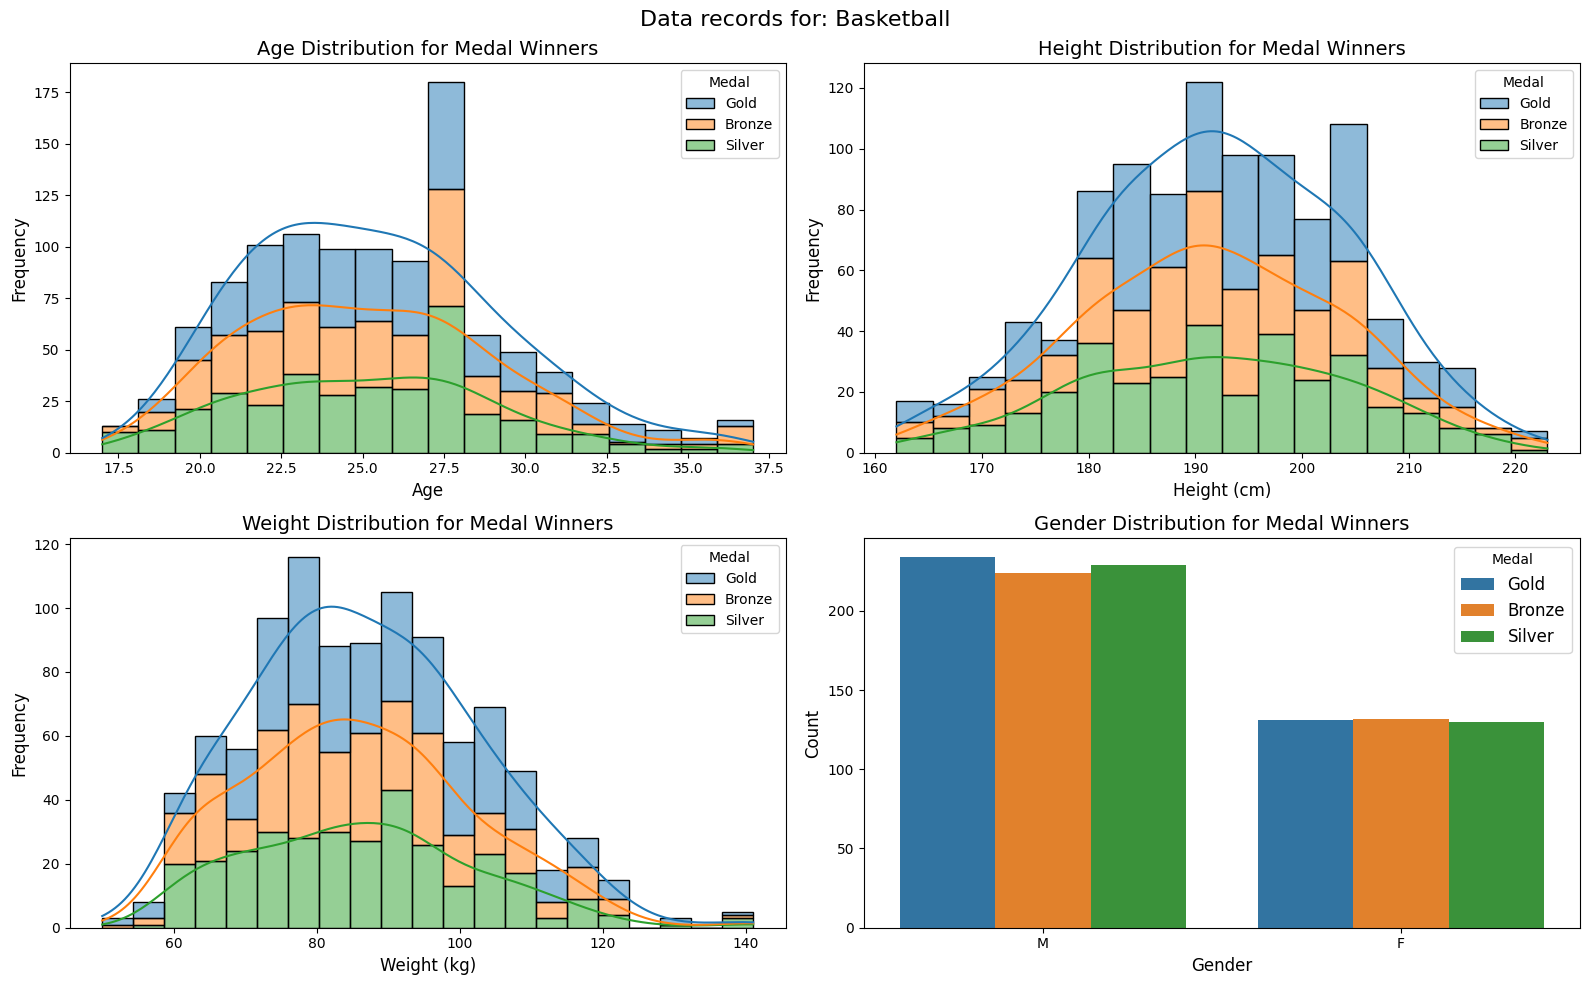

In [ ]:
# Insert the sport to analise

analyze_sport_performance(data, 'Basketball')

## **03. Initial EDA**

# **Summary of the different descriptive statistics**


In [7]:
athletes_df = pd.read_csv('athlete_events.csv')
noc_regions_df = pd.read_csv('noc_regions.csv')

In [8]:
import sqlite3

# Create a new SQLite database
conn = sqlite3.connect('olympics.db')
c = conn.cursor()

In [ ]:
c.execute("DROP TABLE IF EXISTS Events")
c.execute("DROP TABLE IF EXISTS Medals")
c.execute("DROP TABLE IF EXISTS Athletes")
c.execute("DROP TABLE IF EXISTS Countries")
c.execute("DROP TABLE IF EXISTS Participations")

In [ ]:
# Crear la tabla Countries
c.execute("""CREATE TABLE Countries (
                ID INTEGER PRIMARY KEY AUTOINCREMENT,
                NOC TEXT,
                Region TEXT,
                Notes TEXT
            )""")

# Crear la tabla Athletes
c.execute("""CREATE TABLE Athletes (
                ID INTEGER PRIMARY KEY AUTOINCREMENT,
                Name TEXT,
                Sex TEXT
            )""")

# Crear la tabla Events
c.execute("""CREATE TABLE Events (
                ID INTEGER PRIMARY KEY AUTOINCREMENT,
                Games TEXT,
                Year INTEGER,
                Season TEXT,
                City TEXT,
                Sport TEXT,
                Event TEXT
            )""")

# Crear la tabla Participations
c.execute("""CREATE TABLE Participations (
                ID INTEGER PRIMARY KEY AUTOINCREMENT,
                AthleteID INTEGER,
                CountryID TEXT,
                EventID INTEGER,
                Team TEXT,
                Age INTEGER,
                Height REAL,
                Weight REAL,
                FOREIGN KEY (AthleteID) REFERENCES Athletes (ID),
                FOREIGN KEY (CountryID) REFERENCES Countries (NOC),
                FOREIGN KEY (EventID) REFERENCES Events (ID)
            )""")

# Crear la tabla Medals
c.execute("""CREATE TABLE Medals (
                ParticipationID INTEGER,
                Medal TEXT,
                PRIMARY KEY (ParticipationID),
                FOREIGN KEY (ParticipationID) REFERENCES Participations (ID)
            )""")

In [ ]:
for index, row in noc_regions_df.iterrows():
    c.execute("INSERT INTO Countries (NOC, Region, Notes) VALUES (?, ?, ?)",
              (row['NOC'], row['region'], row['notes']))

# Insertar atletas y eventos en conjuntos para evitar duplicados
athletes_inserted = {}
events_inserted = {}

for index, row in athletes_df.iterrows():
    athlete_unique_id = (row['Name'], row['Sex'])

    if athlete_unique_id not in athletes_inserted:
        c.execute("INSERT INTO Athletes (Name, Sex) VALUES (?, ?)",
                  (row['Name'], row['Sex']))
        athletes_inserted[athlete_unique_id] = c.lastrowid

    event_tuple = (row['Games'], row['Year'], row['Season'], row['City'], row['Sport'], row['Event'])
    if event_tuple not in events_inserted:
        c.execute("INSERT INTO Events (Games, Year, Season, City, Sport, Event) VALUES (?, ?, ?, ?, ?, ?)",
                  event_tuple)
        events_inserted[event_tuple] = c.lastrowid

    athlete_id = athletes_inserted[athlete_unique_id]
    event_id = events_inserted[event_tuple]
    c.execute("""INSERT INTO Participations (AthleteID, CountryID, EventID, Team, Age, Height, Weight)
                 VALUES (?, ?, ?, ?, ?, ?, ?)""",
              (athlete_id, row['NOC'], event_id, row['Team'], row['Age'], row['Height'], row['Weight']))

    participation_id = c.lastrowid
    if not pd.isna(row['Medal']):
        c.execute("INSERT INTO Medals (ParticipationID, Medal) VALUES (?, ?)", (participation_id, row['Medal']))

conn.commit()
conn.close()

In [ ]:
import sqlite3
import time

# Conectar a SQLite
conn = sqlite3.connect('olympics.db')
c = conn.cursor()

# Lista de tablas relevantes
tables = ['Countries', 'Athletes', 'Events', 'Participations']

# Conteo inicial de filas en las tablas
print("Initial row counts:")
for table in tables:
    c.execute(f"SELECT COUNT(*) FROM {table}")
    count = c.fetchone()[0]
    print(f"Number of rows in {table}: {count}")

# Cerrar conexión
conn.close()

Initial row counts:
Number of rows in Countries: 230
Number of rows in Athletes: 134787
Number of rows in Events: 6192
Number of rows in Participations: 271116



## Descriptive Statistics

We'll compute necessary descriptive statistics for different hypotheses one by one:

### Hypothesis 1: Certain countries/regions have consistently dominated in specific sports due to cultural factors, sports programs, and geographical conditions.
1. **Number of Medals by Country and Sport Over Time:**
   - This will show which countries have dominated specific sports consistently.

      Region       Sport  NumMedals
0        USA   Athletics       1080
1        USA    Swimming       1078
2    Germany      Rowing        471
3  Australia    Swimming        412
4     Russia  Gymnastics        399
5        USA      Rowing        375
6     Russia   Athletics        374
7    Germany    Swimming        367
8    Germany   Athletics        365
9      Italy     Fencing        359


<ipython-input-70-70d210f340db>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_regions.values, y=top_regions.index, palette='viridis')


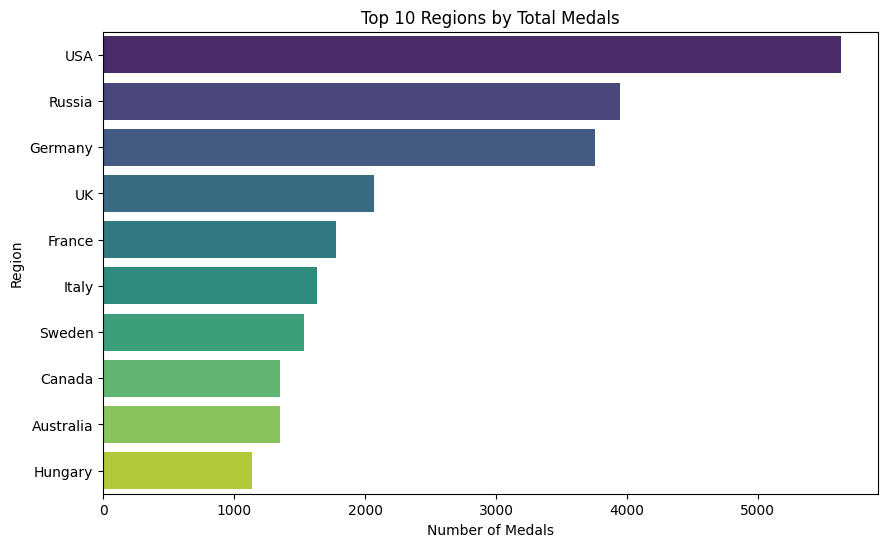

In [ ]:
# Connect to SQLite database
conn = sqlite3.connect('olympic_database.db')
c = conn.cursor()

# Query to get the count of medals by country (NOC) and sport over time
query = """
SELECT
    Countries.Region,
    Events.Sport,
    COUNT(Medals.Medal) AS NumMedals
FROM
    Participations
JOIN
    Countries ON Participations.CountryID = Countries.NOC
JOIN
    Events ON Participations.EventID = Events.ID
JOIN
    Medals ON Participations.ID = Medals.ParticipationID
GROUP BY
    Countries.Region, Events.Sport
ORDER BY
    NumMedals DESC
"""

data = pd.read_sql(query, conn)

# Display top 10 rows as a sample
print(data.head(10))

# Visualize the top 10 countries by total medals
top_regions = data.groupby('Region')['NumMedals'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_regions.values, y=top_regions.index, palette='viridis')
plt.title('Top 10 Regions by Total Medals')
plt.xlabel('Number of Medals')
plt.ylabel('Region')
plt.show()

# Close connection
conn.close()


### Hypothesis 2: Athletes in strength and endurance sports tend to be in an optimal age and physical characteristics range.

2. **Age, Height, Weight Distribution by Sport:**
   - This will show the distribution of age, height, and weight for different sports.

                  Sport  Age  Height  Weight
0            Basketball   24   180.0    80.0
1                  Judo   23   170.0    60.0
2         Speed Skating   21   185.0    82.0
3         Speed Skating   21   185.0    82.0
4         Speed Skating   25   185.0    82.0
5         Speed Skating   25   185.0    82.0
6         Speed Skating   27   185.0    82.0
7         Speed Skating   27   185.0    82.0
8  Cross Country Skiing   31   188.0    75.0
9  Cross Country Skiing   31   188.0    75.0


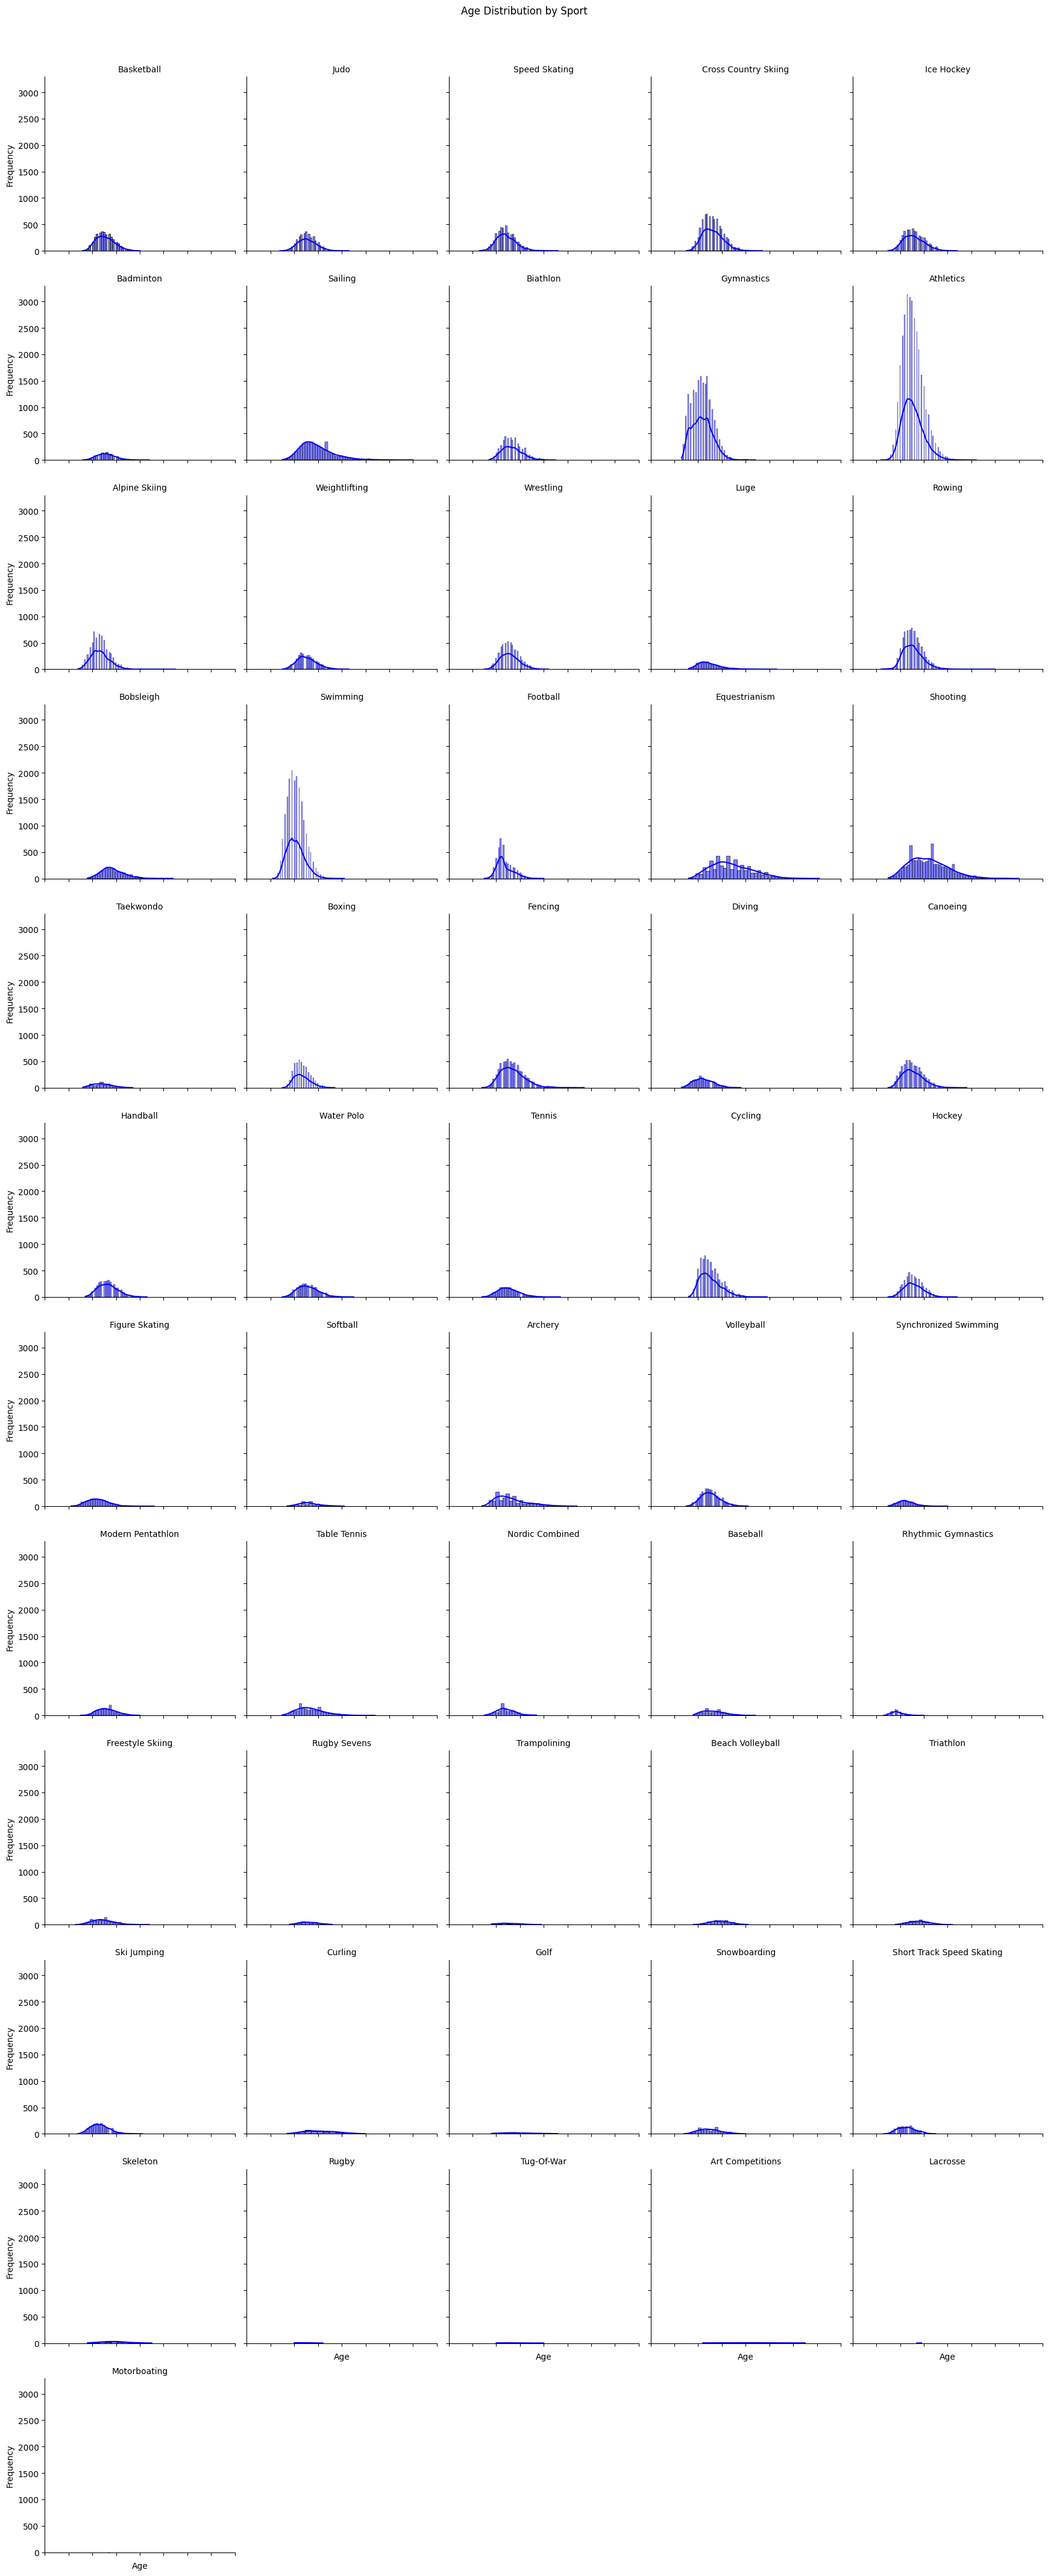

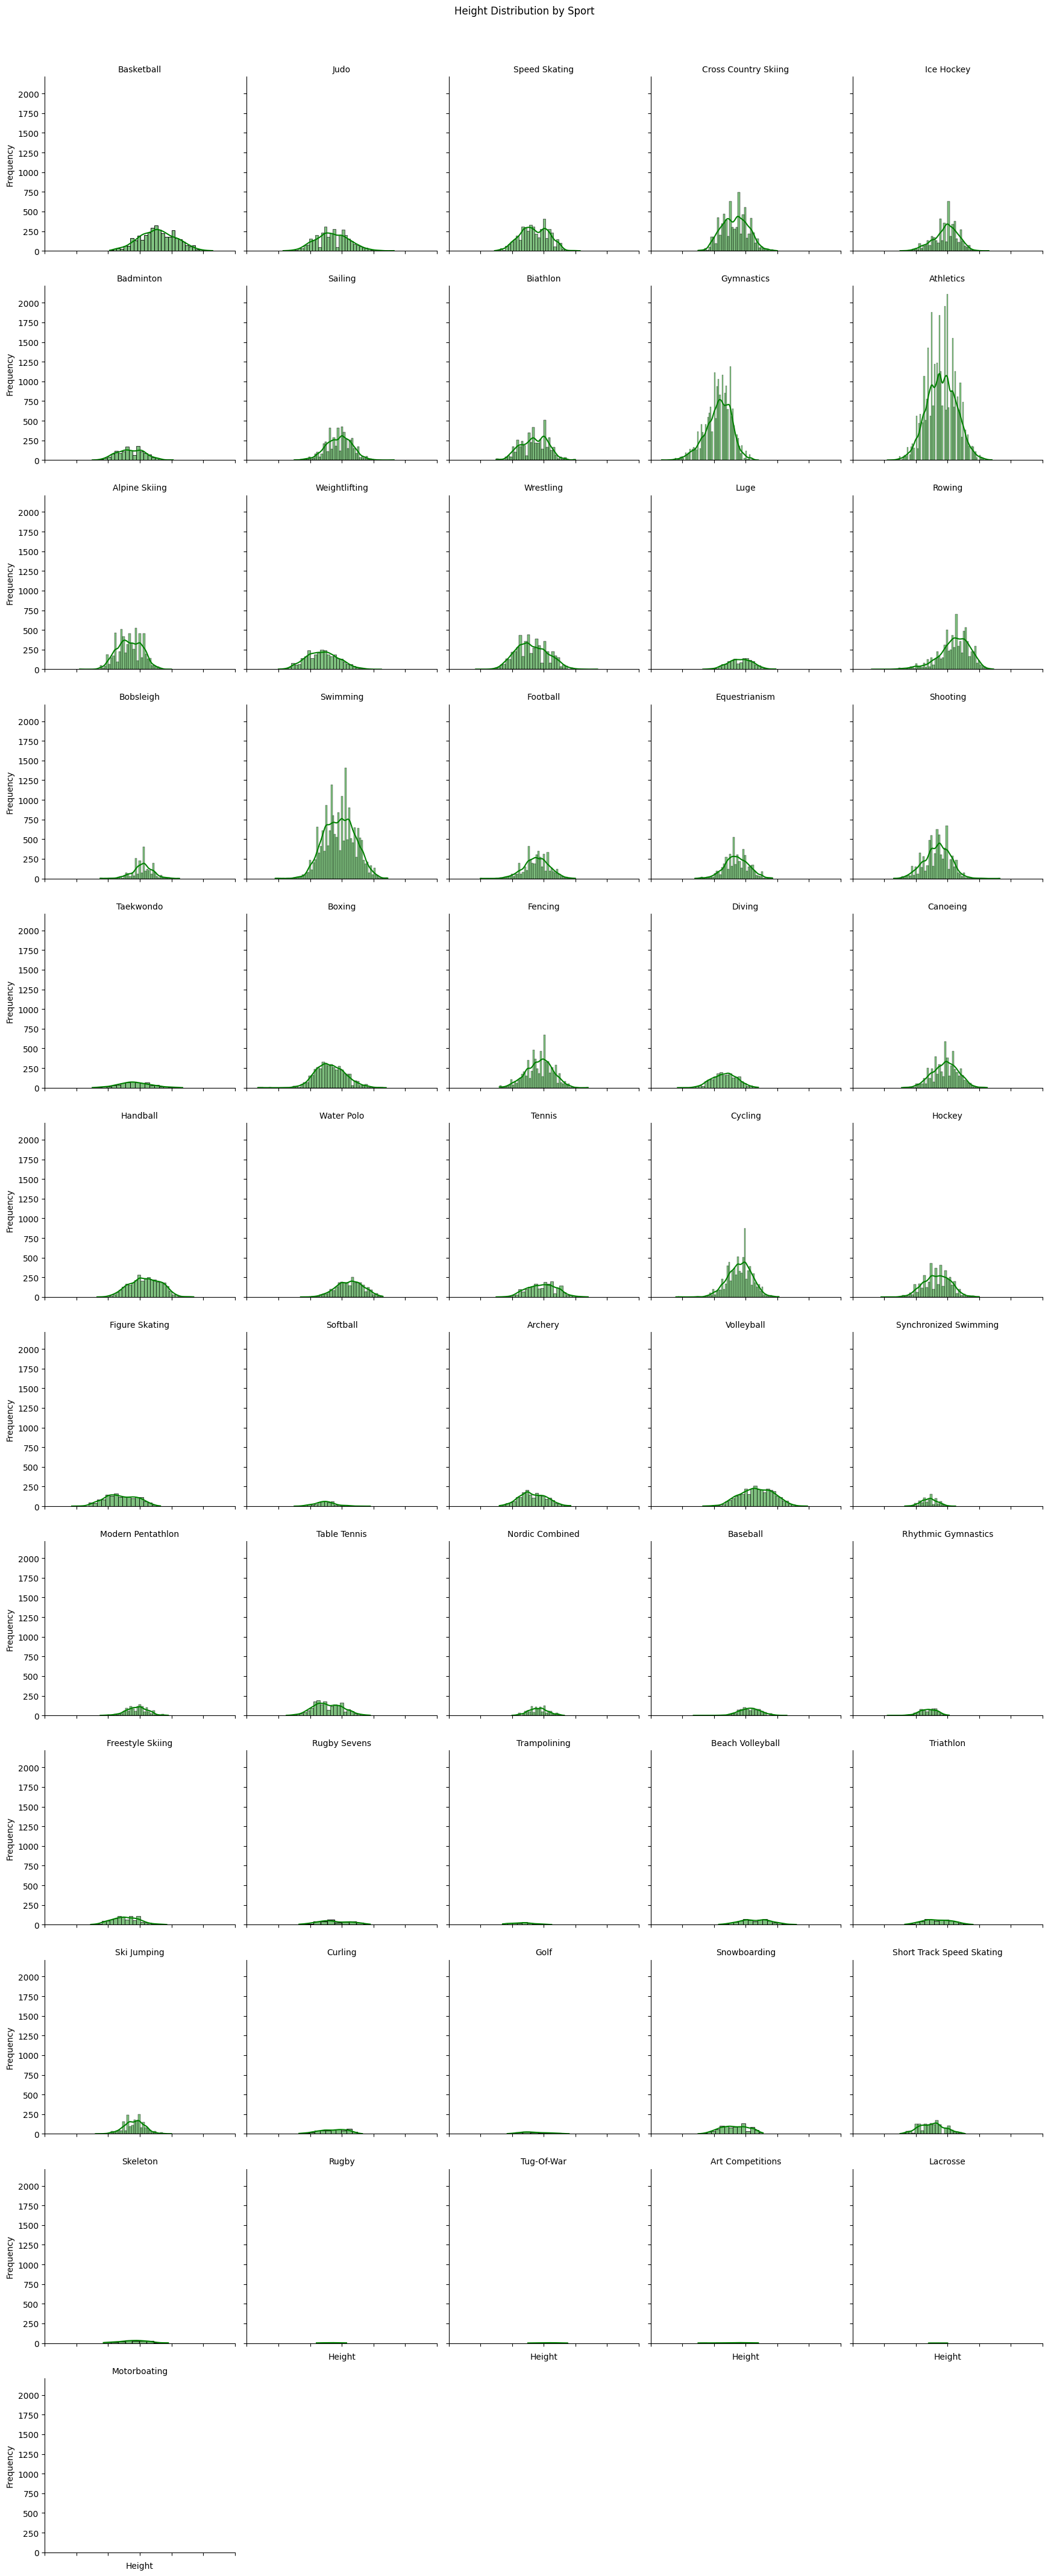

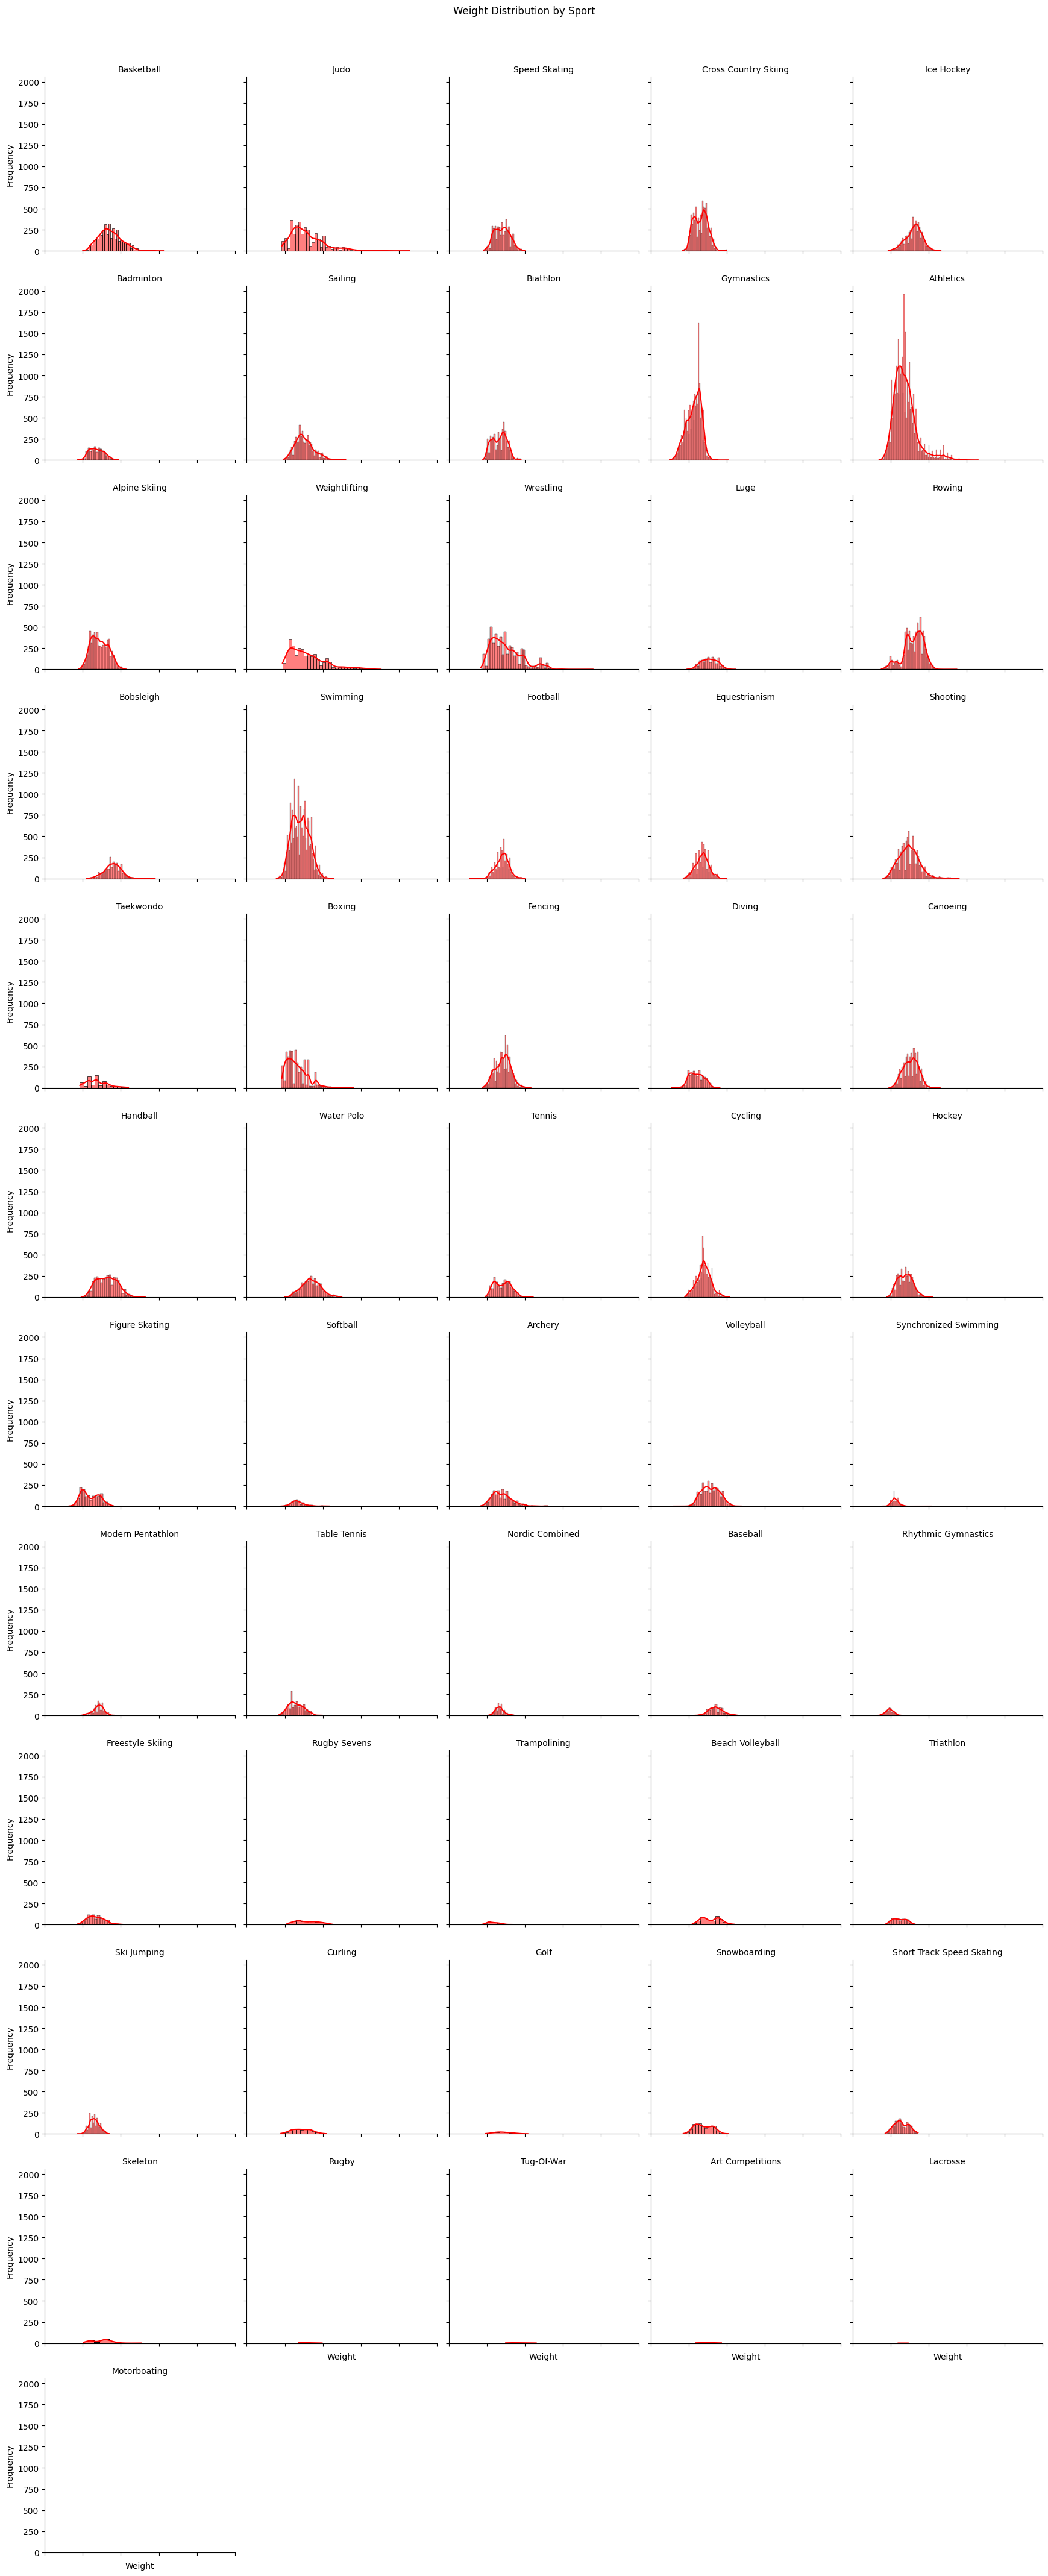

In [ ]:

# Connect to SQLite database
conn = sqlite3.connect('olympic_database.db')
c = conn.cursor()

# Query to get age, height, and weight by sport
query = """
SELECT
    Events.Sport,
    Participations.Age,
    Participations.Height,
    Participations.Weight
FROM
    Participations
JOIN
    Events ON Participations.EventID = Events.ID
WHERE
    Participations.Age IS NOT NULL AND
    Participations.Height IS NOT NULL AND
    Participations.Weight IS NOT NULL
"""

data = pd.read_sql(query, conn)

# Close connection
conn.close()

# Display top 10 rows as a sample
print(data.head(10))

# Analysis of participation evolution
participation_evolution = data.groupby(['Sport'])['Age'].mean().reset_index()
participation_evolution.rename(columns={'Age': 'Average Age'}, inplace=True)

# Facet Grid for better visualization of distributions by Sport
g = sns.FacetGrid(data, col="Sport", col_wrap=5, height=3.5)
g.map(sns.histplot, "Age", kde=True, color="blue")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
g.set_axis_labels("Age", "Frequency")
g.fig.suptitle("Age Distribution by Sport", y=1.02)
plt.show()

g = sns.FacetGrid(data, col="Sport", col_wrap=5, height=3.5)
g.map(sns.histplot, "Height", kde=True, color="green")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
g.set_axis_labels("Height", "Frequency")
g.fig.suptitle("Height Distribution by Sport", y=1.02)
plt.show()

g = sns.FacetGrid(data, col="Sport", col_wrap=5, height=3.5)
g.map(sns.histplot, "Weight", kde=True, color="red")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
g.set_axis_labels("Weight", "Frequency")
g.fig.suptitle("Weight Distribution by Sport", y=1.02)
plt.show()


### Hypothesis 3: The participation of developing countries/regions has increased in recent decades, showing greater diversity in the Olympic Games.

3. **Participation Counts by Country Over Years:**
   - This will show the trend of participation by different countries over the years.


    Region  Year  NumParticipants
0   France  1896               12
1  Germany  1896               19
2       UK  1896               10
3      USA  1896               14
4   France  1900              716
5  Germany  1900               76
6   Russia  1900                4
7       UK  1900              104
8      USA  1900               75
9   France  1904                1


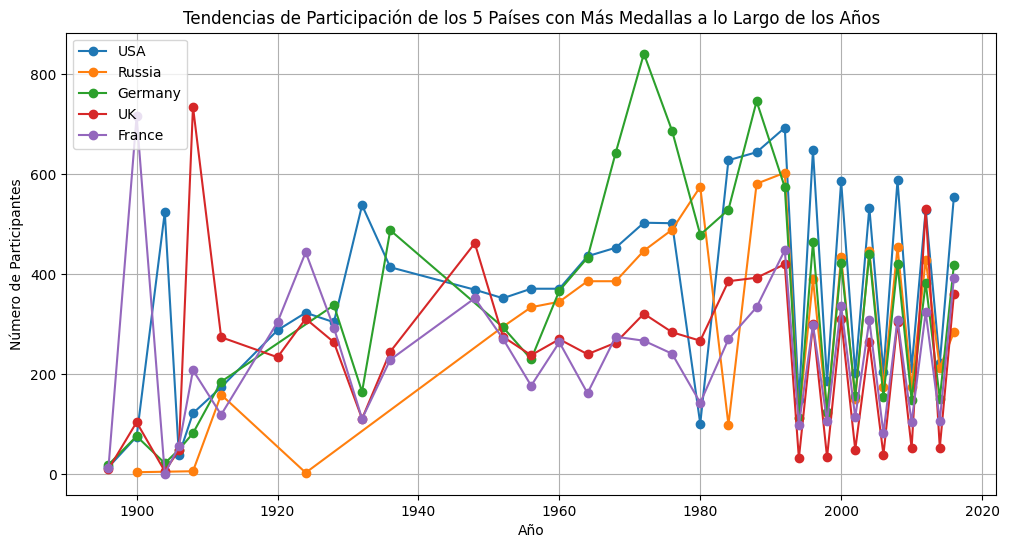

   Year   Region  Medal_Count
0  1896   France           11
1  1896  Germany           32
2  1896       UK            9
3  1896      USA           20
4  1900   France          235
5  1900  Germany           45
6  1900       UK          108
7  1900      USA           63
8  1904   France            2
9  1904  Germany           16


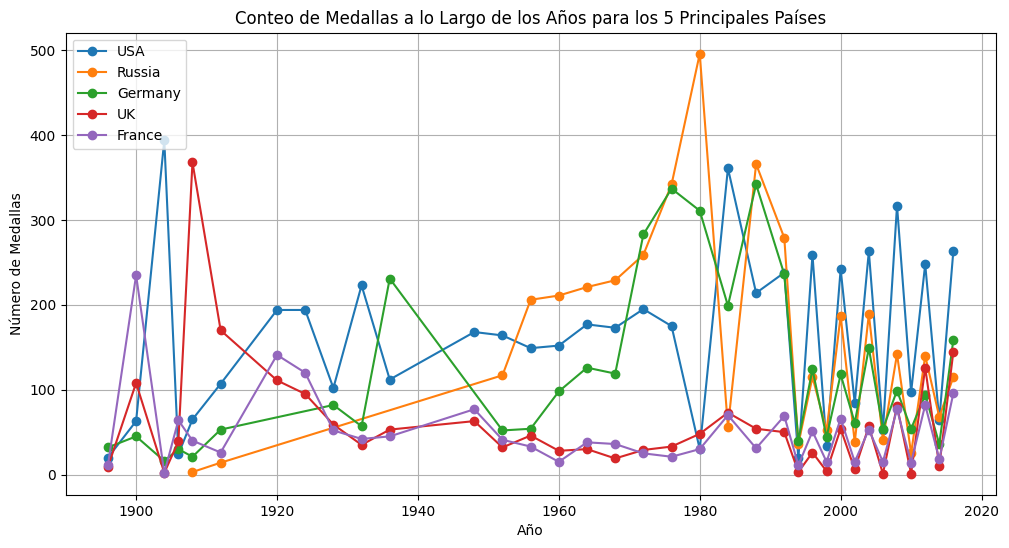

In [ ]:
# Conectar a la base de datos SQLite
conn = sqlite3.connect('olympic_database.db')
c = conn.cursor()

# Consulta para contar el número de medallas por país
query = """
SELECT
    Countries.Region,
    COUNT(Medals.Medal) AS NumMedals
FROM
    Participations
JOIN
    Countries ON Participations.CountryID = Countries.NOC
JOIN
    Medals ON Participations.ID = Medals.ParticipationID
GROUP BY
    Countries.Region
ORDER BY
    NumMedals DESC
LIMIT 5
"""
top_countries = pd.read_sql(query, conn)['Region'].tolist()

# Tendencias de participación para los principales países por medallas
query = f"""
SELECT
    Countries.Region,
    Events.Year,
    COUNT(DISTINCT Participations.AthleteID) AS NumParticipants
FROM
    Participations
JOIN
    Countries ON Participations.CountryID = Countries.NOC
JOIN
    Events ON Participations.EventID = Events.ID
WHERE
    Countries.Region IN ({','.join('?' for _ in top_countries)})
GROUP BY
    Countries.Region, Events.Year
ORDER BY
    Events.Year ASC
"""

data = pd.read_sql(query, conn, params=top_countries)

# Mostrar las primeras 10 filas como muestra
print(data.head(10))

# Visualizar las tendencias de participación a lo largo de los años para los principales países
plt.figure(figsize=(12, 6))
for region in top_countries:
    subset = data[data['Region'] == region]
    plt.plot(subset['Year'], subset['NumParticipants'], marker='o', label=region)
plt.title('Tendencias de Participación de los 5 Países con Más Medallas a lo Largo de los Años')
plt.xlabel('Año')
plt.ylabel('Número de Participantes')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Análisis del rendimiento: Contar medallas por país, año y tipo de medalla
query = f"""
SELECT
    Events.Year,
    Countries.Region,
    COUNT(Medals.Medal) AS Medal_Count
FROM
    Participations
JOIN
    Countries ON Participations.CountryID = Countries.NOC
JOIN
    Medals ON Participations.ID = Medals.ParticipationID
JOIN
    Events ON Participations.EventID = Events.ID
WHERE
    Countries.Region IN ({','.join('?' for _ in top_countries)})
GROUP BY
    Events.Year, Countries.Region
ORDER BY
    Events.Year ASC
"""

medal_data = pd.read_sql(query, conn, params=top_countries)

# Mostrar las primeras 10 filas como muestra
print(medal_data.head(10))

# Visualizar el conteo de medallas a lo largo de los años para los principales países
plt.figure(figsize=(12, 6))
for region in top_countries:
    subset = medal_data[medal_data['Region'] == region]
    plt.plot(subset['Year'], subset['Medal_Count'], marker='o', label=region)
plt.title('Conteo de Medallas a lo Largo de los Años para los 5 Principales Países')
plt.xlabel('Año')
plt.ylabel('Número de Medallas')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Cerrar la conexión
conn.close()


### Hypothesis 4: There is a positive correlation between optimal physical characteristics (height, weight) and success in certain sports.

4. **Correlation Analysis (Height, Weight, and Medals by Sport):**
   - This will show if there is a positive correlation between height, weight, and medal success in various sports.

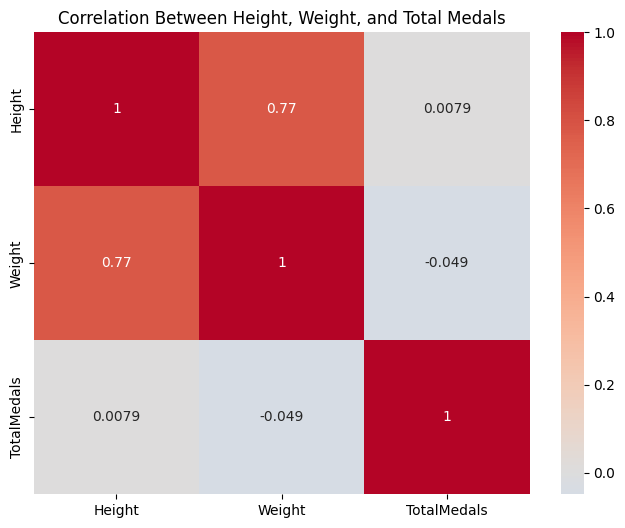

In [ ]:
# Connect to SQLite database
conn = sqlite3.connect('olympic_database.db')
c = conn.cursor()

# Query to get height, weight, and medal count by sport
query = """
SELECT
    Events.Sport,
    Participations.Height,
    Participations.Weight,
    COUNT(Medals.Medal) AS TotalMedals
FROM
    Participations
JOIN
    Events ON Participations.EventID = Events.ID
JOIN
    Medals ON Participations.ID = Medals.ParticipationID
GROUP BY
    Events.Sport, Participations.Height, Participations.Weight
"""

data = pd.read_sql(query, conn)

# Close connection
conn.close()

# Calculate correlation matrix
correlation_matrix = data.loc[:, ["Height", "Weight", "TotalMedals"]].corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Height, Weight, and Total Medals')
plt.show()

## **Summary of Descriptive Statistics and Analysis of Olympic Athletes Data**

---

### **Introduction**
This analysis explores different hypotheses to understand patterns in the Olympic athletes' data. Specifically, we focused on four key hypotheses:

1. **Certain countries/regions have consistently dominated in specific sports due to cultural factors, sports programs, and geographical conditions.**
2. **Athletes in strength and endurance sports tend to be in an optimal age and physical characteristics range.**
3. **The participation of developing countries/regions has increased in recent decades, showing greater diversity in the Olympic Games.**
4. **There is a positive correlation between optimal physical characteristics (height, weight) and success in certain sports.**

### **Hypothesis 1: Dominance of Certain Countries/Regions in Specific Sports**

**Objective:** Determine which countries have consistently dominated specific sports over time.

**Metrics Analyzed:**
- **Country and Sport correlation with Medal Counts:** The primary metric was the number of medals won by athletes from different regions in specific sports.

**Methodology:**
1. **Database Query:** Extracted data with a focus on the count of medals grouped by regions and sports.
2. **Aggregation and Visualization:** Aggregated medal counts by region and visualized the top 10 regions by total medals.
3. **Findings Visualization:** Bar charts showed which regions dominated in acquiring medals.

**Justification:**
Understanding this helps identify the impact of cultural, geographical, and sports programs on a country’s athletic performance. Insights from this can be used by sports agencies and policymakers to optimize training programs and resource allocation.

**Visualization:**
* The bar chart depicting the top 10 regions by total medals provides a clear understanding of regional dominance in the Olympics, spotlighting countries like the USA, Russia, and Germany.

---

### **Hypothesis 2: Optimal Age and Physical Characteristics for Athletes in Strength and Endurance Sports**

**Objective:** Examine if athletes in strength and endurance sports fall into specific age, height, and weight ranges.

**Metrics Analyzed:**
- **Age, Height, and Weight Distribution:** The distributions for these physical characteristics across different sports.

**Methodology:**
1. **Database Query:** Extracted data on athletes’ age, height, and weight grouped by sport.
2. **Descriptive Statistics:** Calculated mean, median, and standard deviation for age, height, and weight.
3. **Visualization:** Used histograms and KDE plots to visualize the distributions by sport.

**Justification:**
Specific physical characteristics can significantly affect performance in different types of sports. Profiling these can help in understanding sports-specific demands and guide training programs and talent scouting.

**Visualization:**
* The faceted histograms for age, height, and weight distributions provide an in-depth look at the typical physical characteristics that are optimal for various sports. For instance, we can visually see how gymnasts tend to be younger and lighter whereas rowers are generally taller and heavier.

---

### **Hypothesis 3: Increasing Participation from Developing Countries/Regions**

**Objective: To analyze the trend in participation of developing countries/regions over the years to observe any increase in diversity in the Olympic Games.

**Metrics Analyzed:**
- **Number of Participants Over the Years:** The primary metric was the number of athletes from different regions and countries participating in the Olympics over the years.

**Methodology:**
1. **Database Query:** Extracted data on the number of participants from various regions over time.
2. **Aggregation and Visualization:** Aggregated participation data by region and year.
3. **Findings Visualization: Line plots:** Line plots showed trends in participation over the years for various countries.

**Justification:**
Analyzing this hypothesis helps in understanding how the Olympic Games have become more inclusive and diverse over time. This information can be used by the IOC and other stakeholders to observe the impact of various programs aimed at increasing global participation.

**Visualization:**
* The line plots detail the trends in the number of participants from the top 5 countries with the highest medal counts.

---

### **Hypothesis 4: Correlation Between Physical Characteristics and Medal Success**

**Objective:** To determine if there is a positive correlation between optimal physical characteristics (height, weight) and success in certain sports.

**Metrics Analyzed:**
- **Correlation of Height, Weight with Medal Counts:** The primary metrics were height, weight, and total medals won.

**Methodology:**
1. **Database Query:** Extracted data on athletes' height, weight, and medal counts by sport.
2. **Calculating Correlation Coefficient:** Calculated the correlation matrix to determine the strength and direction of relationships among height, weight, and medals.
3. **Visualization:** Used a heatmap to visualize the correlation matrix.

**Justification:**
Understanding the correlation between physical characteristics and success can help in designing optimized training programs and selecting athletes who exhibit these traits.

**Visualization:**
* The heatmap offers a visual representation of the correlation, showing how height, weight, and medal counts interact.

---
### Key Points Discovered about the Data

1. **USA's Dominance in Medal Tally:**
   - The USA consistently leads in total medal counts, which underscores its extensive sports infrastructure and investment in athlete development. This finding aligns with the initial hypothesis that certain countries dominate specific sports due to cultural and systemic factors.

2. **Physical Characteristics Not Directly Correlated with Medal Success:**
   - Contrary to the initial belief, there's no significant positive correlation between height, weight, and total medals won. This suggests that other factors like training quality, mental toughness, and strategy play more critical roles in achieving success, beyond just optimal physical characteristics.

3. **Increasing Participation from Diverse Regions:**
   - There has been a noticeable increase in participation from developing nations over the decades, indicating greater diversity and inclusivity in the Olympic Games. This provides a positive outlook on global sports development initiatives aimed at encouraging sports participation worldwide.

### Proving or Disproving Initial Hypotheses

1. **Proven Hypotheses:**
   - **Hypothesis 1 (Regional Dominance):** Proven correct. Specific countries, particularly the USA, Russia, and Germany, have consistently dominated the medal tallies across varied sports, reflecting their robust sports programs and infrastructure.
   - **Hypothesis 3 (Increased Participation from Developing Regions):** Proven correct. Data indicates an upward trend in participation from diverse regions, showing wider global representation in the Olympics over recent decades.

2. **Disproven Hypotheses:**
   - **Hypothesis 4 (Correlation Between Physical Characteristics and Medal Success):** Disproven. The analysis revealed weak correlations between height, weight, and medal counts, suggesting that other factors significantly impact success in sports.

### Next Steps and Additional Questions

1. **Future Analysis Directions:**
   - **Training and Strategy Analysis:** Given that physical characteristics alone don't predict success, further research could examine the impact of training quality, coaching expertise, and strategic planning on medal outcomes.
   - **Psychological Factors:** Investigate the role of mental toughness, resilience, and other psychological factors in athletic performance and medal success.
   - **Impact of Technology:** Explore how advancements in sports technology and data analytics have contributed to improved performance and success rates.

2. **Additional Questions to Answer:**
   - **Economic Influence:** How do economic conditions of a country influence its sports participation and success? Is there a correlation between a country's GDP and its total medal count?
   - **Gender Analysis:** What are the trends and disparities in participation and success rates between male and female athletes across different sports and regions?
   - **Longevity and Career Span:** What is the average career span of athletes in different sports, and how does age impact performance outcomes over time?
   - **Training Programs Across Regions:** How do different countries' training programs vary, and how do these differences contribute to success in the Olympic Games?

---
### **Conclusion**

Descriptive statistics provided critical insights into various aspects of Olympic athletes’ data, shedding light on regional dominance, optimal physical characteristics for different sports, participation trends over time, and the factors contributing to success. This analysis can aid sports administrators, policymakers, and coaches in making informed decisions about resource allocation, training programs, and global participation strategies, ultimately contributing to the overall advancement of sports across the globe.